<a href="https://colab.research.google.com/github/mohiiieldin/Predict-Future-Sales-Competition-on-Kaggle/blob/master/Predict_Future_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import sqrt
from datetime import datetime, timedelta,date
import seaborn as sns
import geopy.distance
from sklearn.metrics import mean_squared_error
#importing machine learning libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

#importing regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm

#ignoring warnings
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV

# time seires staff
# time seires staff
import statsmodels.api as sm
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Reading Data
item_categories = pd.read_csv("/content/gdrive/My Drive/GP Data/item_categories-translated.csv") 
items = pd.read_csv("/content/gdrive/My Drive/GP Data/items-translated.csv")
sales = pd.read_csv("/content/gdrive/My Drive/GP Data/sales_train_v2.csv")
shops = pd.read_csv("/content/gdrive/My Drive/GP Data/shops-translated.csv")
test = pd.read_csv("/content/gdrive/My Drive/GP Data/test.csv")


Let's take a look on the data

In [4]:
print("----------Shape of Data----------")
print(sales.shape)
print("----------first 5 rows----------")
print(sales.head(5))
print("-----------data frame overview-----------")
print(sales.info())
print("----------Missing value-----------")
print(sales.isnull().sum())

----------Shape of Data----------
(2935849, 6)
----------first 5 rows----------
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
-----------data frame overview-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
----------Missing val

1) Date 

In [5]:

# changing the type of the column into date time, this will ease future feature engineering
sales.date = pd.to_datetime(sales.date)
print("First date --> " , sales.date.min())
print("Last date --> " , sales.date.max())

First date -->  2013-01-01 00:00:00
Last date -->  2015-12-10 00:00:00


2) date_block_num

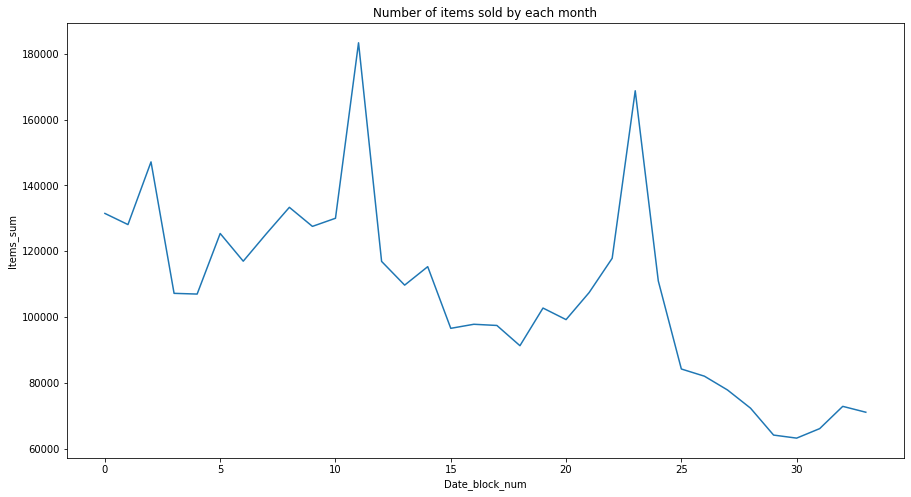

In [6]:
#what is the number of items soled at each month ?
sales_grouped_by_month =  sales.groupby('date_block_num')['item_cnt_day'].sum()
plt.figure(figsize=(15,8))
plt.title("Number of items sold by each month")
plt.xlabel("Date_block_num")
plt.ylabel("Items_sum")
sns.lineplot(data = sales_grouped_by_month)

3) shop_id

In [0]:
print("Nuumber of shops is : ",sales.shop_id.nunique())

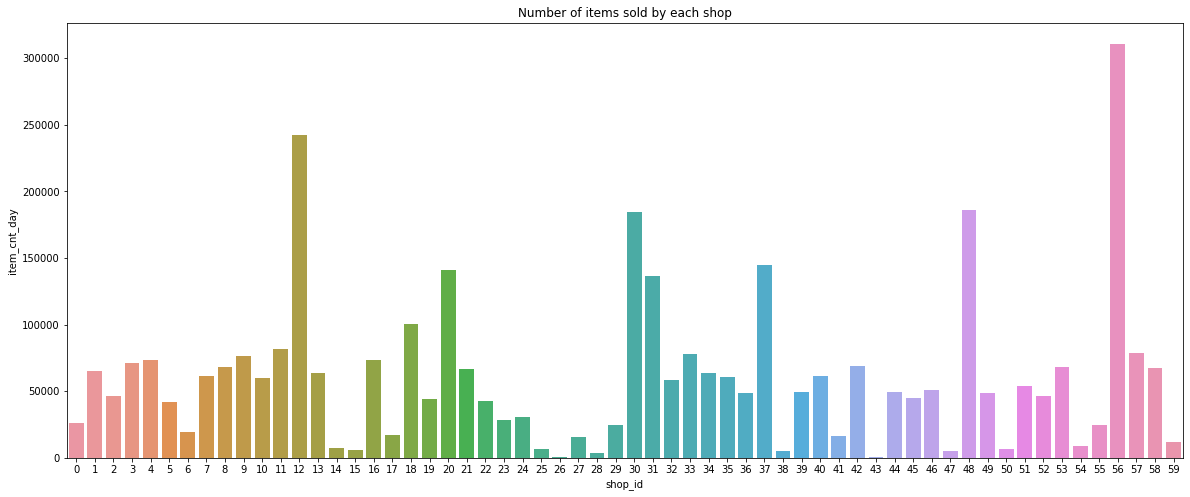

In [7]:
# what is the number of items soled at each shop ?
items_ordered_grouped_by_shop =  sales.groupby('shop_id')['item_cnt_day'].sum()
plt.figure(figsize=(20,8))
plt.title("Number of items sold by each shop")
plt.xlabel("shop_id")
plt.ylabel("Items_mean")
sns.barplot(x = sales.shop_id.unique(),y =  items_ordered_grouped_by_shop )

There is a significant difference between the shops in terms number of ordered items.

4) item_id

In [0]:
#number of unique items
print(sales.item_id.nunique())
best_5_items = sales.groupby("item_id")['item_cnt_day'].sum().sort_values(ascending = False ).head(5)
items_info = items[items.item_id.isin(best_5_items.index)].sort_values(by = 'item_id')
items_info

In [0]:
plt.figure(figsize = (20,8))
plt.title("Most 5 items ordered")
plt.xlabel("Item Name")
plt.ylabel("Number of ordered items")
sns.barplot(x = items_info.item_name_translated.values , y = best_5_items.values)

This is a big number compared to the other !

5) item_price

In [0]:
print(sales.item_price.describe().round(2))
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_price)

6) item_cnt_day (target variable):

In [0]:
print(sales.item_cnt_day.describe().round())
plt.figure(figsize = (20 , 8))
sns.boxplot(sales.item_cnt_day)

# Time series forcasting

# 1)Arima ( AutoRegressive Integrated Moving Average )

# Machine Learning

In [0]:
# Getting ready for the base model
base = sales.copy() # leaving the original dataset untouched
base = pd.DataFrame(base.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum())
base = base.reset_index() 
base = base.rename(columns = {'item_cnt_day':'item_cnt_month'})
base

In [0]:
def get_data_splits(df , split_fraction = 0.2) :
    """
    Splits a dataframe into 80% train, 20% validation but first order by the date_block_num. 
    
    """
    #df = df.sort_values(by = 'date_block_num') #sort values by the date_clock_num so that the test set is the last period of time
    num_of_rows = int(len(df) * split_fraction)
    train = df[ :-num_of_rows ]
    validation = df[-num_of_rows : ]
    
    return train, validation

In [0]:
train, validation = get_data_splits(base)

In [0]:

X_train = train.drop('item_cnt_month' , axis = 1)
y_train = train.item_cnt_month

X_val = validation.drop('item_cnt_month' , axis = 1)
y_val = validation.item_cnt_month


models = []
models.append(('XGB' , XGBRegressor()) )
models.append(('RF' ,RandomForestRegressor(verbose = False ,random_state = 1) ))
models.append(('LR' ,LinearRegression() ))
for name, model in models :
    model.fit(X_train, y_train)
    rmse = sqrt( mean_squared_error(model.predict(X_val), y_val ) ) 
    print(name ,": ",rmse )


In [0]:
# These are the values of the base model and wull be improved after every part in the notebook
XGB :  7.175706496337836
RF :  8.50106502627325
LR :  8.036103975520204

In [0]:
# i want to insert in the first position the date_block_num to match the test with the train
test.insert(0 , 'date_block_num' , [34 for i in range(0, len(test) )])
test = test.drop('ID' , axis= 1)
test

In [0]:
# submitting to the leaderboard
xgb = XGBRegressor(verbose = False , max_depth = 10)
xgb.fit(base.drop('item_cnt_month',axis = 1), base.item_cnt_month)
preds_xgb = xgb.predict(test)
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('sub.csv' , index = False)

I got about 6 RMSE with the base model

# Feature Engineering

In [0]:
sales1 = base.copy() # Continue on the base model

In [0]:
# what is the portion of data that has target variable value with more than 20
round((len(base[base.item_cnt_month > 20]) / len(base)),3)


item_cnt_day has natural ouliers with values more than 20 and although they represent the real life but they are not a lot and make a lot of niose to the model so i will trim any value more than 20 and we will lose a small fraction of the data anyways



In [0]:
sales1 = sales1[sales1.item_cnt_month <= 20]
print(sales1.item_cnt_month.describe().round())
plt.figure(figsize = (20 , 8))
sns.boxplot(sales1.item_cnt_month)
plt.show()

In [0]:
# Validating after trimming the target variabel
train, validation = get_data_splits(sales1)
X_train = train.drop('item_cnt_month' , axis = 1)
y_train = train.item_cnt_month

X_val = validation.drop('item_cnt_month' , axis = 1)
y_val = validation.item_cnt_month


models = []
models.append(('XGB' , XGBRegressor()) )
models.append(('tree' ,DecisionTreeRegressor() ))
for name, model in models :
    model.fit(X_train, y_train)
    rmse = sqrt( mean_squared_error(model.predict(X_val), y_val ) ) 
    print(name ,": ",rmse )

In [0]:
XGB :  1.8130931833250858
tree :  2.557620589777995

Trimming the target variable improved the performance a lot

# Mean Encoding

`Motivation` : the item_id is not ordinal and if we one hot encoded it we will fall in the curse of dimensionality hence mean encoding is needed to solve this trap.

In [0]:
from itertools import product # to make cartisien product
index_cols = ['shop_id' , 'item_id' , 'date_block_num']
grid = []
for block_num in sales.date_block_num.unique() : # iterating over the 34 month
    curr_shops = sales[sales.date_block_num == block_num]['shop_id'].unique() # get the unique shops in this month
    curr_items = sales[sales.date_block_num == block_num]['item_id'].unique() # get the unique items in this month
    grid.append(np.array(list(product (*[ curr_shops, curr_items, [block_num]]))))
grid = pd.DataFrame(np.vstack(grid) , columns = index_cols ) 
all_data = grid.merge(sales1 , how = 'left' , on = index_cols).sort_values(index_cols).fillna(0)
all_data.info

In [0]:
def downcasting(df) :
    """
    make 2 lists onc contains index of float64 columns and the other int64 or int32,
    then change the dtype of these column into less memory consumer data type
    """
    float_cols = [ col for col in df if df[col].dtype == "float64" ]
    int_cols = [col for col in df if df[col].dtype in ['int64','int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [0]:
all_data = downcasting(all_data)
all_data.info()

In [0]:
# Mean encoding with The naive method
all_data['item_target_enc'] = all_data.groupby('item_id')['item_cnt_month'].transform('mean').fillna()
all_data = all_data.fillna(all_data.item_cnt_month.mean() , inplace = True) #  fill na that happend from values in validation not in the train with the global mean   
all_data

In [0]:
# Validating the mean encoding
train, validation = get_data_splits(all_data.drop('item_id', axis = 1))
X_train = train.drop('item_cnt_month' , axis = 1)
y_train = train.item_cnt_month

X_val = validation.drop('item_cnt_month' , axis = 1)
y_val = validation.item_cnt_month


models = []
models.append(('XGB' , XGBRegressor()) )
for name, model in models :
    model.fit(X_train, y_train)
    rmse = sqrt( mean_squared_error(model.predict(X_val), y_val ) ) 
    print(name ,": ",rmse )

In [0]:
XGB :  1.114534640907537

It worked will in decreased the RMSE

In [0]:
all_data.drop('item_target_enc',axis = 1 , inplace = True)


Working with regularized mean encoding in order to decrease the leakage

In [0]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5 , shuffle = False)
for train_ind, val_ind in kf.split(all_data) :
    train_data , val_data = all_data.iloc[train_ind], all_data.iloc[val_ind]
    all_data.loc[all_data.index[val_ind] , 'item_target_enc'] = val_data['item_id'].map(train_data.groupby('item_id')['item_cnt_month'].mean())
    
all_data['item_target_enc'].fillna(all_data.item_cnt_month.mean(), inplace=True) # fill na that happend from values in validation not in the train with the global mean    

In [0]:
# making a column to map it to the test set
item_mean_enc = all_data.groupby('item_id')['item_target_enc'].unique()
item_mean_enc = item_mean_enc.apply(lambda x: x.mean())

test['item_target_enc'] = test['item_id'].map(item_mean_enc) # mapping the variable in the test 
test.fillna(all_data.item_cnt_month.mean() , inplace = True)
test

In [0]:
# sorting the columns names in train and test dataframse in the same order
all_data = all_data.reindex(sorted(all_data.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)

In [0]:
xgb = XGBRegressor(verbose = False )
xgb.fit(all_data_lags.drop(['item_cnt_month','item_id'],axis = 1), all_data.item_cnt_month)

In [0]:
# submitting in the leaderboard
preds_xgb = xgb.predict(test_lags1.drop('item_id',axis = 1))
sub = sample_submission
sub.item_cnt_month = preds_xgb
sub.to_csv('xgb_lags.csv' , index = False)

In [0]:
XGB : 1.09881

# Adding lags

In [0]:
all_data_lags = all_data.copy()
lag_list = [1, 2, 3 ]
for lag in lag_list:
    all_data_lags['item_cnt_month_lag' + str(lag)] =  all_data_lags.item_cnt_month.shift(lag , axis = 0)
base2.fillna(0 , inplace = True)    

In [0]:
lag_list = [1, 2, 3]
all_data_lags = all_data.copy()

for lag in lag_list:
    ft_name = ('itemm_cnt_month_shifted%s' % lag)
    all_data_lags[ft_name] = all_data_lags.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt_month'].shift(lag)
    # Fill the empty shifted features with 0
    all_data_lags[ft_name].fillna(0, inplace=True)

In [0]:
all_data_lags[all_data_lags.item_id ==13881 ].sort_values(['date_block_num','shop_id']).tail(60)

In [0]:
lag_list = [1, 2, 3]
subset_data = all_data[(all_data.date_block_num ==33) | (all_data.date_block_num ==32)| (all_data.date_block_num ==31)]
test_lags = test.copy()
for lag in lag_list:
    ft_name = ('itemm_cnt_month_shifted%s' % lag)
    test_lags[ft_name] = subset_data.sort_values('date_block_num').groupby(['shop_id','item_id'])['item_cnt_month'].shift(lag)
    # Fill the empty shifted features with 0
    #all_data_lags[ft_name].fillna(0, inplace=True)

In [0]:
def get_test_lags(all_data , test, lag) :
    
    shifted = test[['date_block_num','shop_id','item_id', 'item_cnt_month']]
    shifted.columns = ['date_block_num','shop_id','item_id', 'itemm_cnt_month_shifted'+ str(lag)]
    shifted['date_block_num'] += lag
    test_lag = pd.merge(all_data, shifted, on=['date_block_num','shop_id','item_id'] , how = 'left')
    return test_lag['itemm_cnt_month_shifted'+ str(lag)] #return the last column (the lags) 

In [0]:
test_lags = test.copy()
all_data_l = all_data_lags.copy()
all_data_l['date_block_num'] += 1
test_lags1 = test_lags.merge(all_data_l[['date_block_num','shop_id','item_id', 'item_cnt_month','itemm_cnt_month_shifted1','itemm_cnt_month_shifted2']] , how = 'left' , on =['date_block_num', 'item_id','shop_id'] )
test_lags1 = test_lags1.rename(columns = {'item_cnt_month':'itemm_cnt_month_shifted1' , 'itemm_cnt_month_shifted1':'itemm_cnt_month_shifted2','itemm_cnt_month_shifted2':'itemm_cnt_month_shifted3'})

In [0]:
test_lags1.fillna(0,inplace = True)

In [0]:
test_lags = test.copy()
test_lags[item_cnt_month] = 0
for lag in range(1,4):
    lag_values = get_test_lags(all_data ,test_lags, lag)
    test_lags['itemm_cnt_month_shifted'+ str(lag)] = lag_values

Adding category id

In [0]:
all_data_lags = all_data_lags.merge(items[['item_id','item_category_id']])
all_data_lags

# hyper paramter tuning

In [0]:
from scipy import stats
kfold = KFold(n_splits=5, random_state=0 , shuffle = False)
param_dist = {'n_estimators': stats.randint(100, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.3, 0.9),
              'max_depth': [5, 6, 7, 8, 9,10,11,12],
              'colsample_bytree': stats.uniform(0.5, 0.9),
              'min_child_weight': [1, 2, 3, 4]
             }

xgb_model = XGBRegressor()
grid_search = RandomizedSearchCV(estimator = xgb_model, param_distributions = param_dist, n_jobs=-1 ,iid=False,
                                 verbose=10,scoring='neg_mean_squared_error' , cv=kfold,)
model = grid_search.fit(train , )

print('best params')
print (grid_search.best_params_)
print('best score')
print (grid_search.best_score_)


In [0]:
#from sklearn.feature_selection import SelectKBest, chi2
#from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import mean_squared_error

clf = XGBRegressor(random_state=0 )
search_space = [
  {
    'clf__n_estimators': [ 500 , 600 , 700 , 800 , 900 ],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 8),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__k': [10],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=0 , shuffle = False)

scoring = 'neg_mean_squared_error'
# Define grid search
grid = RandomizedSearchCV(
  estimator = clf,
  param_grid=search_space,
  cv=kfold,
  scoring='neg_mean_squared_error',
  verbose=1,
  refit = True,
  n_jobs=-1
)
# Fit grid search
model = grid.fit(base.drop('item_cnt_month', axis = 1), base.item_cnt_month)
print('Best RMSE Score: {}'.format(model.best_score_))

In [0]:
preds = model.predict(test)
sub = sample_submission
sub.item_cnt_month = preds
sub1.to_csv('C:\\Users\\Mohie eldin\\Desktop\\sub.csv' , index = False)